# IMDB_LSTM_HAN_complete - 94.73%
- 181204

In [1]:
# data : imdb unzip하여 다운
# wget https://www.kaggle.com/c/word2vec-nlp-tutorial/download/labeledTrainData.tsv
# 이름바꾸고 unzip

# HAN 코드 출처
# https://www.kaggle.com/sermakarevich/hierarchical-attention-network/comments
# https://richliao.github.io/supervised/classification/2016/12/26/textclassifier-HATN/

In [2]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os
from nltk import tokenize

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding, RepeatVector, Permute, Multiply, Lambda, BatchNormalization, LeakyReLU
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout, LSTM, CuDNNLSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model
from keras.callbacks import EarlyStopping, LearningRateScheduler, Callback, ModelCheckpoint

from keras.optimizers import Adam, Adadelta, SGD


from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

from tqdm import tqdm
import math
from matplotlib import pyplot as plt
import seaborn as sn
from colored import fg, bg, attr

Using TensorFlow backend.


In [3]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

data_dir = 'data/'
os.makedirs(data_dir, exist_ok=True)
data1 = 'data/labeledTrainData.tsv'
data2 = 'data/imdb_master.csv'

In [4]:
Learning_Rate = 0.0002

# Learning_Rate_Mode = 'SGD'
# Learning_Rate_Mode = 'Amsgrad'
Learning_Rate_Mode = 'Adam'
# Learning_Rate_Mode = 'Adadelta'    
    
    
SEQ_LEN = 100  # magic number - length to truncate sequences of words
lstm_dim = 100
dense_dim = 20
dense_dropout = 0.2
nb_classes = 2
epoch = 10
batch_size = 64

# imdb data 불러오기 + 데이타 전처리

In [5]:
# imdb 1, labeledTrainData.tsv
data_1 = pd.read_csv( data1 , delimiter='\t')
print(data_1.shape)
data_1 = data_1.drop(['id'], axis=1)
data_1.head()

(25000, 3)


,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [6]:
# imdb 2, imdb_master.csv
data_2 = pd.read_csv( data2 ,encoding="latin-1")
data_2 = data_2.drop(['Unnamed: 0','type','file'],axis=1)
data_2.columns = ["review","sentiment"]
data_2 = data_2[data_2.sentiment != 'unsup']
data_2['sentiment'] = data_2['sentiment'].map({'pos': 1, 'neg': 0})
data_2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [7]:
# 두 데이타 합치기
data = pd.concat([data_1, data_2], sort=True).reset_index(drop=True, )
data_copy = data
print(data_copy.shape)
data_copy.head()

(75000, 2)


,review,sentiment
0,With all this stuff going down at the moment w...,1
1,"\The Classic War of the Worlds\"" by Timothy Hi...",1
2,The film starts with a manager (Nicholas Bell)...,0
3,It must be assumed that those who praised this...,0
4,Superbly trashy and wondrously unpretentious 8...,1


In [9]:
# 자연어처리, 전처리
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# stopword, lemmatizer 불러오기
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
# 
def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = re.sub(r'<br />','',text, re.UNICODE)
    text = re.sub(r'â','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")] # token 단위 lemmati
    text = [lemmatizer.lemmatize(token, "v") for token in text] # 동사 lemmati
    text = [word for word in text if not word in stop_words]  #stopword 없애고
    text = " ".join(text)  # 뛰어쓰기추가
    return text

data_copy['Processed_Reviews'] = data_copy.review.apply(lambda x: clean_text(x))
print(data_copy.shape)
data_copy[:3]

(75000, 3)


,review,sentiment,Processed_Reviews
0,With all this stuff going down at the moment w...,1,stuff go moment mj ive start listen music watc...
1,"\The Classic War of the Worlds\"" by Timothy Hi...",1,classic war world timothy hines entertain film...
2,The film starts with a manager (Nicholas Bell)...,0,film start manager nicholas bell give welcome ...


In [10]:
reviews = []
labels  = []
texts   = []

for idx in range(data_copy.review.shape[0]):
    text = data_copy.review[idx]
#     text = text.get_text().encode('ascii', 'ignore')
#     text = clean_str(text)
    text = clean_text(text)   # 캐글 전처리기 사용
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)

    labels.append(data_copy.sentiment[idx])

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

# text가 여러 문장으로 되어있는 review 이다. 그러므로 document지
# 입력데이타 : [ N , 최대문장수, 최대문장길이]
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
print(data.shape)

/home/go/.local/lib/python3.6/site-packages/keras_preprocessing/text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


(75000, 15, 100)


In [11]:
for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if 'â' not in word:
                    try:
                        if k < MAX_SENT_LENGTH and tokenizer.word_index[word] < MAX_NB_WORDS:
                            data[i, j, k] = tokenizer.word_index[word]
                            k = k + 1
                    except:
                        print(word)
                        print(sentences)
                
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Number of positive and negative reviews in traing and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_val  : ', x_val.shape)
print('y_val  : ', y_val.shape)

Total 160166 unique tokens.
Shape of data tensor: (75000, 15, 100)
Shape of label tensor: (75000, 2)
Number of positive and negative reviews in traing and validation set
[29934. 30066.]
[7566. 7434.]
x_train:  (60000, 15, 100)
y_train:  (60000, 2)
x_val  :  (15000, 15, 100)
y_val  :  (15000, 2)


In [12]:
GLOVE_DIR = 'glove'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# 입력 : 총 단어 갯수, 103051
# 출력 : EMBEDDING_DIM(200)
# embedding_matrix = (103052, 200)
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=True,
                            mask_zero=True)
print('done')

Total 400000 word vectors.
done


In [13]:
# visualize
def highlight(c, power):
    if power >= 0.5:
        print('{}{}{}{}'.format(bg(160), attr(1), c, attr(0)), end='')
    elif power >= 0.4:
        print('{}{}{}{}'.format(bg(196), attr(1), c, attr(0)), end='')
    elif power >= 0.3:
        print('{}{}{}{}'.format(bg(210), attr(1), c, attr(0)), end='')
    elif power >= 0.2:
        print('{}{}{}{}'.format(bg(217), attr(1), c, attr(0)), end='')
    elif power >= 0.1:
        print('{}{}{}{}'.format(bg(224), attr(1), c, attr(0)), end='')
    elif power > 0.0:
        print('{}{}{}{}'.format(bg(225), attr(1), c, attr(0)), end='')
    else:
        print(c, end='')
        
# visualize
def highlight_normalize(c, power, power_min, power_max):
    # 글자, power, 그 파워의 최소값, 최대값
    # 최대, 최소값으로 0~1 normalize
    power = (power - power_min) / (power_max - power_min)
    
    if power >= 0.9:
        print('{}{}{}{}'.format(bg(160), attr(1), c, attr(0)), end='')
    elif power >= 0.8:
        print('{}{}{}{}'.format(bg(196), attr(1), c, attr(0)), end='')
    elif power >= 0.6:
        print('{}{}{}{}'.format(bg(210), attr(1), c, attr(0)), end='')
    elif power >= 0.4:
        print('{}{}{}{}'.format(bg(217), attr(1), c, attr(0)), end='')
    elif power >= 0.2:
        print('{}{}{}{}'.format(bg(224), attr(1), c, attr(0)), end='')
    elif power > 0.0:
        print('{}{}{}{}'.format(bg(225), attr(1), c, attr(0)), end='')
    else:
        print(c, end='')

In [14]:
class AttentionLayer(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
#     def __init__(self, attention_dim, **kwargs):
    def __init__(self, **kwargs):
#         self.attention_dim = attention_dim

        self.init = initializers.get('glorot_uniform')
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer=self.init,
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(input_shape[-1], ),
                                 initializer=self.init,
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(input_shape[-1], 1),
                                 initializer=self.init,
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        
        # RNN 구조를 거쳐서 나온 hidden states (x)에 single layer perceptron (tanh activation)
        # 적용하여 나온 벡터가 uit 
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        
        # uit와 uw (혹은 us) 간의 similarity를 attention으로 사용
        # softmax를 통해 attention 값을 확률 분포로 만듬
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

# word-level attention 적용하기 (for sentence representation)

In [15]:
# first, build a sentence encoder
sentence_input = Input(shape=(MAX_SENT_LENGTH, ), dtype='int32')
embedded_sentence = embedding_layer(sentence_input)
# [?,?,200]
bilstm_sentence = Bidirectional(LSTM(lstm_dim, return_sequences=True))(embedded_sentence)

# word attention computation, [?,200]
# word_attention = AttentionWithContext()(bilstm_sentence)
word_attention = AttentionLayer()(bilstm_sentence)
print(word_attention)

# word attention application, [?,200, 200]
# hidden states의 출력에 맞게 scalar를 반복해 (lstm_dim * 2) 크기로 만듬
repeated_word_attention = RepeatVector(lstm_dim * 2)(word_attention)
# Permute 레이어를 사용해 Multiply가 가능하도록 차원 수정, 곱하기 위하여
# [MAX_SENTENCE_LENGTH, lstm_dim * 2] -> [lstm_dim * 2, MAX_SENTENCE_LENGTH] 
repeated_word_attention = Permute([2, 1])(repeated_word_attention)

# compute sentence representation as the weighted sum of word representations
# 곱하고
sentence_representation = Multiply()([bilstm_sentence, repeated_word_attention])
# weighted-sum과정, weighting 해주고 summation, 펼쳐서 수행
sentence_representation = Lambda(lambda x: K.sum(x, axis=1))(sentence_representation)

Tensor("attention_layer_1/Softmax:0", shape=(?, 100), dtype=float32)


# sentence-attention 적용하기 (for document representation)

In [16]:
sentence_encoder = Model(inputs=[sentence_input], 
                         outputs=[sentence_representation])

# then, build a document encoder
document_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
# 입력이 document_input 이므로, sentence 입력으로 바꾸기 위하여
embedded_document = TimeDistributed(sentence_encoder)(document_input)
bilstm_document = Bidirectional(LSTM(lstm_dim, return_sequences=True))(embedded_document)

# sentence attention computation
sentence_attention = AttentionLayer()(bilstm_document)

# sentence attention application
repeated_sentence_attention = RepeatVector(lstm_dim * 2)(sentence_attention)
repeated_sentence_attention = Permute([2, 1])(repeated_sentence_attention)

# compute document representation as the weighted sum of sentence representations
document_representation = Multiply()([bilstm_document, repeated_sentence_attention])
document_representation = Lambda(lambda x: K.sum(x, axis=1))(document_representation)

# sentiment classification 하기

In [17]:
# finally, add fc layers for classification
hidden = BatchNormalization()(document_representation)
hidden = Dense(dense_dim)(hidden)
hidden = LeakyReLU(alpha=0.1)(hidden)
hidden = Dropout(dense_dropout)(hidden)

pred_sentiment = Dense(nb_classes, activation='softmax')(hidden)

model = Model(inputs=[document_input],
            outputs=[pred_sentiment])

# compile
if   Learning_Rate_Mode == 'SGD':
    opt = SGD(lr=Learning_Rate, momentum=0.9, decay=1e-6)
elif Learning_Rate_Mode == 'Amsgrad':
    opt = Adam(lr=Learning_Rate, amsgrad=True)
elif Learning_Rate_Mode == 'Adam':
    opt = Adam(lr=Learning_Rate)
elif Learning_Rate_Mode == 'Adadelta':    
    opt = Adadelta(lr=Learning_Rate)
    
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [18]:
sentence_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 200)     32033400    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 200)     240800      embedding_1[0][0]                
__________________________________________________________________________________________________
attention_layer_1 (AttentionLay (None, 100)          40400       bidirectional_1[0][0]            
__________________________________________________________________________________________________
repeat_vec

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 15, 100)      0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 15, 200)      32314600    input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 15, 200)      240800      time_distributed_1[0][0]         
__________________________________________________________________________________________________
attention_layer_2 (AttentionLay (None, 15)           40400       bidirectional_2[0][0]            
__________________________________________________________________________________________________
repeat_vec

In [20]:
ck_dir = 'models/'
os.makedirs(ck_dir, exist_ok=True)
ck_path = ck_dir + 'model.h5'

checkpoint = ModelCheckpoint(ck_path,
                             monitor='val_acc',
                             verbose=0,
                             save_best_only=True,
                             mode='min')
early_stopping = EarlyStopping(patience = 70)

In [21]:
epoch = 100

print("model fitting - Hierachical attention network")
hist = model.fit( x_train, y_train, 
                  nb_epoch=epoch, 
                  batch_size=batch_size,
                  shuffle=True,
                  callbacks=[checkpoint, early_stopping],
                  validation_data=(x_val, y_val)
                 )

model fitting - Hierachical attention network


/home/go/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 60000 samples, validate on 15000 samples
Epoch 1/100
60000/60000 [==============================] - 494s 8ms/step - loss: 0.3699 - acc: 0.8349 - val_loss: 0.2730 - val_acc: 0.8905
Epoch 2/100
60000/60000 [==============================] - 487s 8ms/step - loss: 0.2474 - acc: 0.9006 - val_loss: 0.2609 - val_acc: 0.8953
Epoch 3/100
60000/60000 [==============================] - 487s 8ms/step - loss: 0.1862 - acc: 0.9299 - val_loss: 0.2398 - val_acc: 0.9024
Epoch 4/100
60000/60000 [==============================] - 486s 8ms/step - loss: 0.1357 - acc: 0.9508 - val_loss: 0.2041 - val_acc: 0.9303
Epoch 5/100
60000/60000 [==============================] - 486s 8ms/step - loss: 0.0927 - acc: 0.9680 - val_loss: 0.2237 - val_acc: 0.9291
Epoch 6/100
60000/60000 [==============================] - 488s 8ms/step - loss: 0.0674 - acc: 0.9773 - val_loss: 0.2842 - val_acc: 0.9186
Epoch 7/100
60000/60000 [==============================] - 487s 8ms/step - loss: 0.0468 - acc: 0.9845 - val_loss: 0.

60000/60000 [==============================] - 487s 8ms/step - loss: 3.2791e-04 - acc: 1.0000 - val_loss: 0.6214 - val_acc: 0.9443
Epoch 60/100
60000/60000 [==============================] - 484s 8ms/step - loss: 0.0021 - acc: 0.9994 - val_loss: 0.6495 - val_acc: 0.9401
Epoch 61/100
60000/60000 [==============================] - 485s 8ms/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.5551 - val_acc: 0.9459
Epoch 62/100
60000/60000 [==============================] - 485s 8ms/step - loss: 0.0022 - acc: 0.9994 - val_loss: 0.5734 - val_acc: 0.9438
Epoch 63/100
60000/60000 [==============================] - 483s 8ms/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.5914 - val_acc: 0.9434
Epoch 64/100
60000/60000 [==============================] - 486s 8ms/step - loss: 3.3717e-04 - acc: 1.0000 - val_loss: 0.6520 - val_acc: 0.9428
Epoch 65/100
60000/60000 [==============================] - 483s 8ms/step - loss: 2.8223e-04 - acc: 1.0000 - val_loss: 0.6681 - val_acc: 0.9435
Epoch 66/100
60000/60

Best validation accuracy :  94.73 %


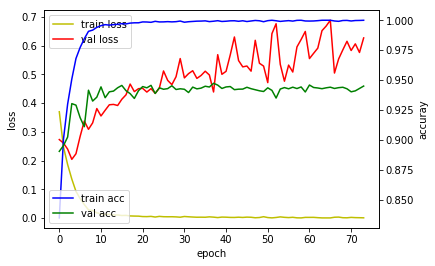

In [81]:
# 5. 모델 학습 과정 표시하기
print('Best validation accuracy : ', round(np.max(hist.history['val_acc'])*100,2), '%')
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# attention 시각화하기
HAN에서는 word-level attention과 sentence-level attention이 함께 쓰입니다. 이 attention들을 분석

In [23]:
# 입력 넛고, word_attention layer 출력, 근데 입력이 document 므로, TimeDistributed로 만들기
word_attention_extractor = Model(inputs=[sentence_input],
                                 outputs=[word_attention])

word_attentions = TimeDistributed(word_attention_extractor)(document_input)

# doc 입력으로 단어레벨, 문장레벨 어텐션 뽑기
attention_extractor = Model(inputs=[document_input],
                            outputs=[word_attentions, sentence_attention])
# (N, 15, 100)
attention_expamle = attention_extractor.predict(x_val[:3])

# word attention visualization

In [24]:
word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

def sentiment_analysis(review): 
    sentences = tokenize.sent_tokenize(review)  # 문단->문장단위로 자르기
    tokenized_sentences = tokenizer.texts_to_sequences(sentences)  # 벡터화
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=MAX_SENT_LENGTH) # 문장 최대길이로 제로패딩, 앞쪽으로 0이 붙는다
    pad_size = MAX_SENTS - tokenized_sentences.shape[0]  # 15 - 6 = 9, 문장단위로는 9번 패딩해야한다

    # tokenized_sentences : [15 , 100]
    if pad_size <= 0:
        tokenized_sentences = tokenized_sentences[:MAX_SENTS]  # 최대 문장수보다 크면 MAX_SENTS 만큼 자르고
    else:
        tokenized_sentences = np.pad(
            tokenized_sentences, ((0, pad_size), (0, 0)),
            mode='constant', constant_values=0
        )  # 그렇지 않으면 죄다 0으로 패딩
    tokenized_sentences_input = np.asarray([tokenized_sentences])  # list를 np array로 변환하여 입력하기 위해

    # 단어기준, 문장기준 어텐션 가져오기, np.asarray를 이용해서 list를 np array로 만들어서 너어준다
    pred_word_attention    = attention_extractor.predict(tokenized_sentences_input)[0]  # [0] : word attention만 가져오기, (1, 15, 100)
    pred_sentence_attention= attention_extractor.predict(tokenized_sentences_input)[1]  # [1] : sentence attention만 가져오기, (1, 15)

    # 문장단위 어탠션 nomalize, [0.30764675, 0.27119225, 0.17760307, 0.11542551, 0.07580608, 0.05232629]
    real_sentence_attention = pred_sentence_attention[0][:-pad_size]
    real_sentence_attention = real_sentence_attention / (np.sum(real_sentence_attention))  # normalize
    real_sentence_attention
    # 문장단위 어텐션 visualize
    print('Sentence attention visualize\n')
    for i, sentence in enumerate(sentences):
        print(round(real_sentence_attention[i],2),': ' , end='')
        for j in sentence:
            highlight_normalize(j, real_sentence_attention[i], np.min(real_sentence_attention), np.max(real_sentence_attention) )
        print()

    # 단어단위 어텐션 visualize
    print('\nword attention visualize\n')
    for i, sentence in enumerate(tokenized_sentences[:-pad_size]):
        # word_rev_index로 idx -> 실제 단어, 0제외
        words = [word_rev_index[word_id] for word_id in sentence if word_id != 0][:50]
        pred_att = np.asarray(pred_word_attention[0][i][::-1][:len(words)][::-1])  # [::-1]로 순서 뒤집고, 단어수만큼만 짜르고, 다시 순서 뒤집어서 단어만 나오도록

        for j, word in enumerate(words):
            highlight_normalize(word, pred_att[j], np.min(pred_att), np.max(pred_att))
            print(' ',end='')
        print()

In [46]:
data_copy[:3]

,review,sentiment,Processed_Reviews
0,With all this stuff going down at the moment w...,1,stuff go moment mj ive start listen music watc...
1,"\The Classic War of the Worlds\"" by Timothy Hi...",1,classic war world timothy hines entertain film...
2,The film starts with a manager (Nicholas Bell)...,0,film start manager nicholas bell give welcome ...


In [70]:
# for i in range(444, 449):
#     review = []
#     review = data_copy.review[i]
#     if data_copy.sentiment[i] == 1:
#         print('긍정', i)
#     else:
#         print('부정', i)
    
#     sentiment_analysis(review)
#     print('\n\n\n')
sentiment_analysis("Delicious healthy food. The steak is amazing. Fish and pork are awesome too. Service is above and beyond. Not a bad thing to say about this place. Worth every penny!")


Sentence attention visualize

0.92 : Delicious healthy food.
0.05 : The steak is amazing.
0.01 : Fish and pork are awesome too.
0.0 : Service is above and beyond.
0.0 : Not a bad thing to say about this place.
0.01 : Worth every penny!

word attention visualize

delicious healthy food 
the steak is amazing 
fish and pork are awesome too 
service is above and beyond 
not a bad thing to say about this place 
worth every penny 


# F1 score 계산

In [26]:
# F1 score & confusion matrix 구하기 위해서 [1,0] -> [True] 식으로 변환
from sklearn.metrics import f1_score, confusion_matrix
prediction = model.predict(x_val)
y_val = y_val
y_pred = (prediction > 0.5)
y_val_temp = (y_val > 0.5)

y_pred = []
for i in range(len(prediction)):
    if prediction[i][1] > 0.5:
        y_pred.append(True)
    else:
        y_pred.append(False)
        
y_val_temp = []
for i in range(len(y_val)):
    if y_val[i][1] == 1:
        y_val_temp.append(True)
    else:
        y_val_temp.append(False)

print('accuracy: {0}'.format(model.evaluate(x_val, y_val)))
print('F1-score: {0}'.format(f1_score(y_pred, y_val_temp)))
print('Confusion matrix:')
print(confusion_matrix(y_pred, y_val_temp))

15000/15000 [==============================] - 82s 5ms/step
accuracy: [0.6269252490109956, 0.9449999999682108]
F1-score: 0.9446791390062361
Confusion matrix:
[[7131  390]
 [ 435 7044]]
